In [65]:
import pandas as pd
import itertools as it
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import os

## Marco teorico

La contaminación en Colombia se produce principalmente por dos causas, la primera se relaciona con la producción y tratamiento de combustibles fósiles para el sostenimiento de diferentes industrias y la segunda con el consumo de energía. 														     

Según el ministerio de ambiente y desarrollo, Colombia emite el 0.37% de los gases de efecto invernadero en el mundo. Posicionando al país en el puesto 137 en el rasquiña de países emisores de CO2 entre 184 países evaluados.														

El aumento de la temperatura planetaria provocada por los gases de efecto invernadero y la tala de bosques genera múltiples perjuicios a la humanidad: desórdenes del clima, tormentas tropicales, sequías, aumento y del nivel de los mares a causa del deshielo de los glaciares.																					   									
Colombia, más que por producir CO2, contribuye al calentamiento global con su enorme deforestación que provoca una serie de consecuencias catastróficas para toda la diversidad de nuestros bosque.

La NASA estima que el gradual aumento de las temperaturas que se registrará en el planeta en el transcurso de las próximas décadas provocará una serie de cambios significativos en el ecosistema, que, probablemete, se incrementen con el tiempo.

La temperatura promedio de la Tierra subió 2 grados Fahrenheit a lo largo del siglo XX y el fenómeno sigue manteniendo esa tendencia. Por eso, a futuro se preven incendios forestales más frecuentes, períodos de sequía más prolongados en algunas regiones y tormentas tropicales más intensas, numerosas y duraderas.

## Lectura y limpieza

In [127]:
temperaturas = pd.read_csv('data/temperaturasCol.csv', skiprows=2) # Lectura de bd.
temperaturas.head() # Encabezado de bd.

,Unnamed: 0,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1901,24.84,25.01,25.30,25.06,24.55,23.90,23.94,24.17,24.23,24.27,24.33,24.34
1,1902,24.54,24.83,24.92,24.78,24.36,23.88,23.76,24.17,24.18,24.30,24.55,24.46
2,1903,24.54,25.00,25.01,24.75,24.37,23.91,23.94,24.17,24.42,24.28,24.35,24.29
3,1904,24.45,25.03,24.87,24.92,24.22,24.08,23.93,24.17,24.42,24.22,24.45,24.32
4,1905,24.43,24.69,24.83,24.79,24.19,23.84,23.94,24.17,24.42,24.34,24.45,24.25


In [128]:
nuevas_columnas = list(temperaturas.columns) # Nombres de columnas.
nuevas_columnas[0] = "Year" # Nombramiento primera columna.
temperaturas.columns = nuevas_columnas # Renombramiento de columnas.

In [129]:
temperaturas = temperaturas.melt(id_vars="Year") 
temperaturas['date'] = temperaturas[['Year', 'variable']].apply(lambda x: str(x['Year']) + '-' + x['variable'],axis=1)
temperaturas['date'] = pd.to_datetime(temperaturas['date'])

In [130]:
temperaturas.sort_values(by = 'date', inplace = True) # Ordenar filas por fecha.
temperaturas.reset_index(inplace = True) # Reiniciar indices.

In [131]:
array = [x for x in range(948, 1452)] # Indices de filas desde 1980.
temperaturas = temperaturas.loc[array] # Seleccion de filas desde 1980.
temperaturas = temperaturas[['date', 'value']] # Seleccion de columnas a usar.
temperaturas.set_index('date', inplace = True) # Pasar fechas a indices.
temperaturas

,value
date,
1980-01-01,25.00
1980-02-01,25.39
1980-03-01,25.70
1980-04-01,25.55
1980-05-01,25.12
...,...
2021-08-01,24.54
2021-09-01,24.88
2021-10-01,25.15


## Selección de modelo



### Análisis descriptivo

<AxesSubplot: title={'center': 'Temperatura promedio en Colombia'}, xlabel='Fecha', ylabel='temperatura'>

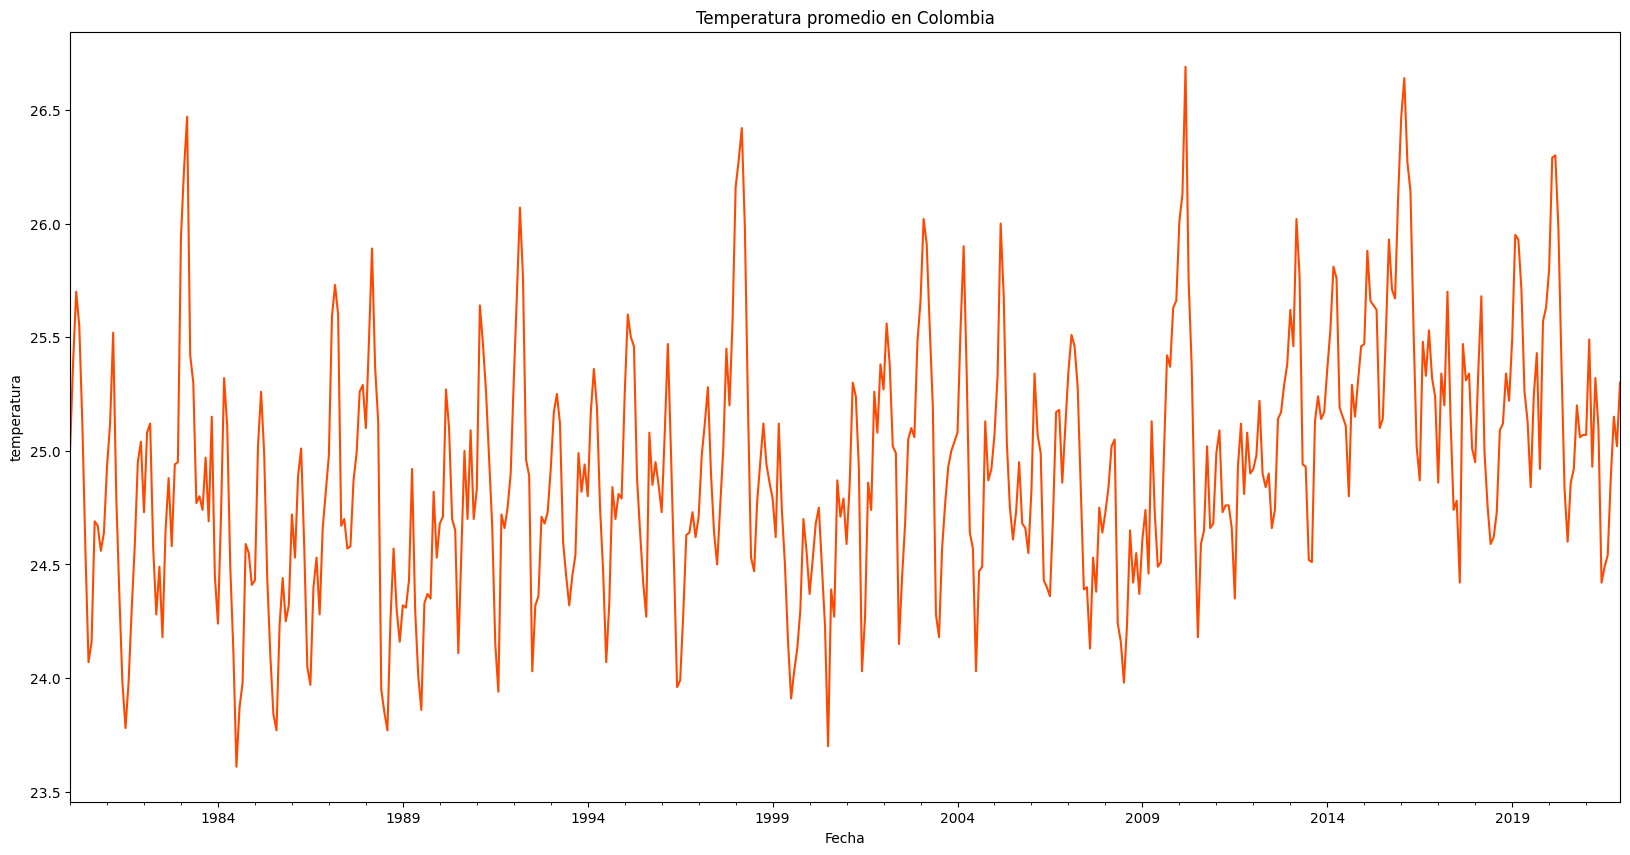

In [45]:
# Grafico serie de tiempo.
temperaturas.plot(figsize = (20,10), 
    title = 'Temperatura promedio en Colombia', color = '#FF4900', 
    xlabel = 'Fecha', ylabel = 'temperatura', legend = False) 

In [47]:
# Test de Dickey Fuller.
adfuller(temperaturas) # Serie estacionaria.

(-4.530835803186129,
 0.00017289408863871783,
 16,
 487,
 {'1%': -3.443849184997939,
  '5%': -2.8674931065091105,
  '10%': -2.569940776113236},
 139.18527494772366)

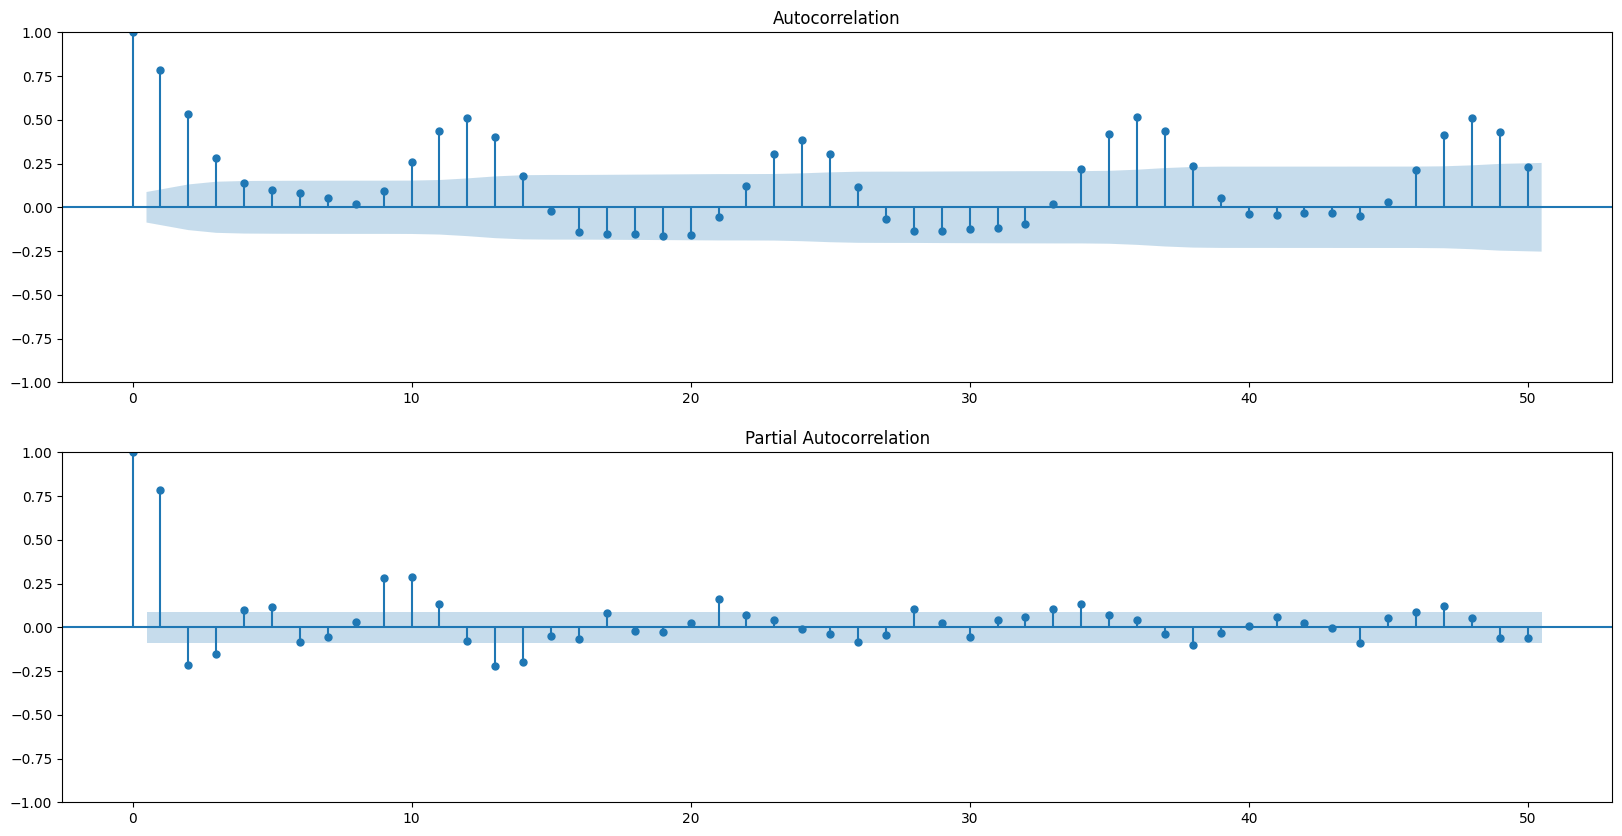

In [46]:
figure, axis = plt.subplots(2,1)
figure.set_size_inches(20,10)

# Graficos de ACF y PACF.
plot_acf(temperaturas, ax=axis[0], lags=50);
plot_pacf(temperaturas, ax=axis[1], method = 'ywm', lags=50);

- Según el test de Dickey Fuller, para la serie original no es necesario aplicar una diferencia, por lo tanto $d = 0$.
- Se presenta un decaimiento exponencial muy lento en los lags $12, 24, 36, ...$. Esto indica que es necesario tomar una diferencia estacional, luego $D = 1$.
- Además, se puede ver en la ACF que la serie presenta una estacionalidad en periodos de 12 meses, $s = 12$.

In [61]:
seriedif12 = temperaturas.diff(12).dropna() # Serie diferenciada anualmente.

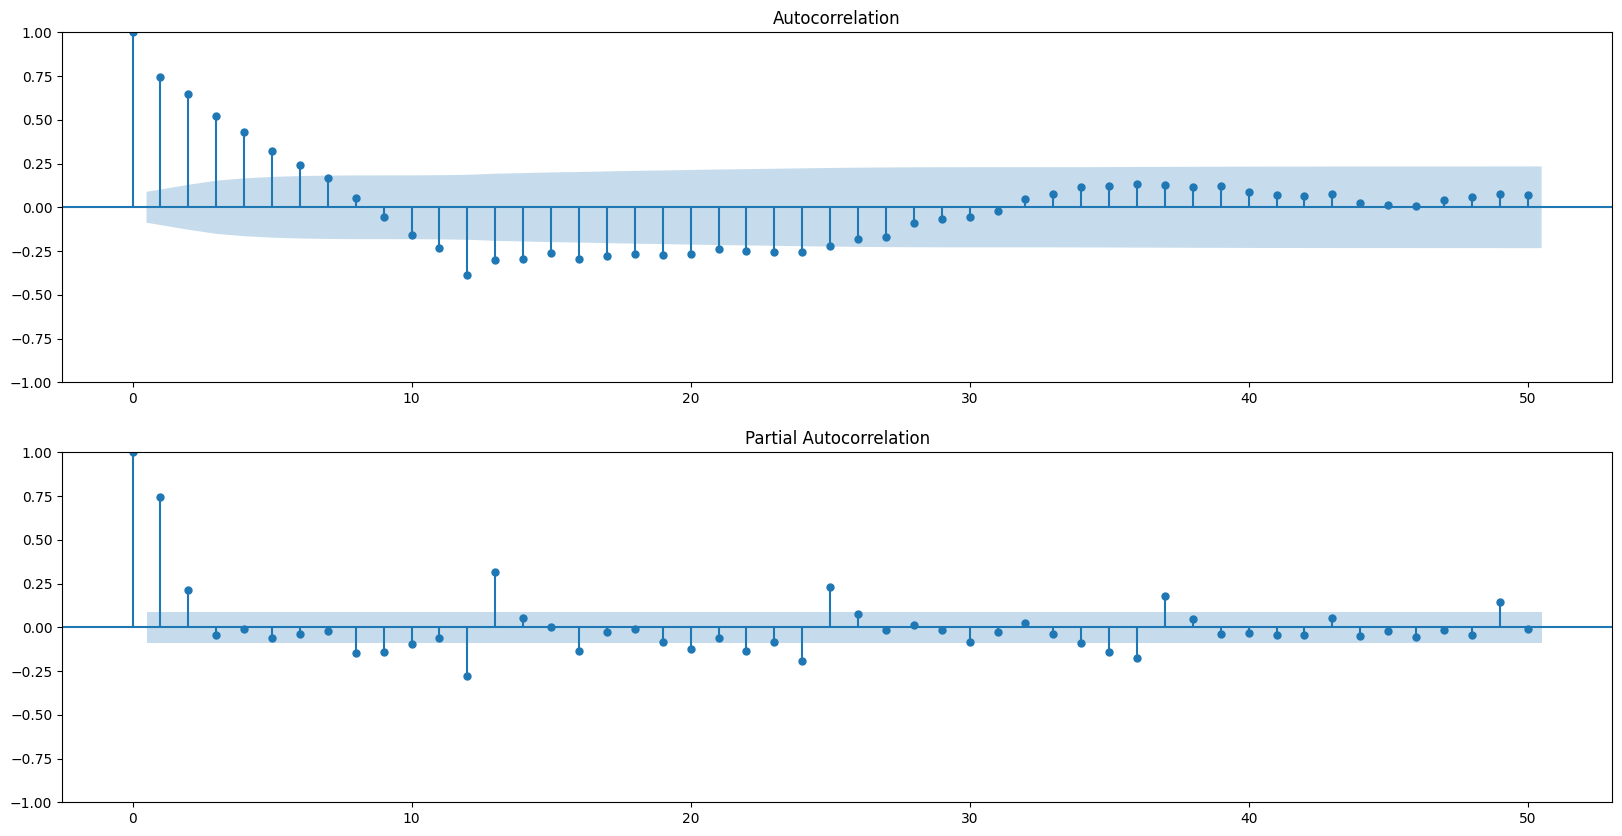

In [62]:
figure, axis = plt.subplots(2,1)
figure.set_size_inches(20,10)

# Graficos de ACF y PACF para serie diferenciada anualmente.
plot_acf(seriedif12, ax=axis[0], lags=50);
plot_pacf(seriedif12, ax=axis[1], method = 'ywm', lags=50);

El comportamiento de la serie diferenciada en el orden 12 no evidencia claramente los ordenes de los parámetros $p, d, P$ y $Q$. Se plantean diferentes modelos y se comparan teniendo en cuento el AIC y BIC para seleccionar el "más" adecuado. 

## Ajuste de modelo

In [132]:
array = np.array([0, 1, 2]) # Valores en los cuales varian p, q, P y Q.
comb = list(it.product(array, repeat = 4)) # Combinaciones posibles de p, q, P y Q.

aic = []; bic = [] # Listas vacias para agregar los AIC y BIC de los modelos.
for i in range(0, len(comb)):
    mod = SARIMAX(temperaturas, # Modelo ajustado.
        order=(comb[i][0], 0, comb[i][1]), 
        seasonal_order=(comb[i][2], 1, comb[i][3], 12)).fit()
    aic.append(mod.aic) 
    bic.append(mod.bic)

resumen = pd.DataFrame(data = {'(p,q,P,Q)' : comb, 'AIC' : aic, 'BIC' : bic}) # bd resumen.

c:\Users\juant\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juant\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juant\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juant\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juant\AppData\Local\Programs\Python\Python310\l

In [133]:
resumen.sort_values(by = 'AIC') # bd ordenada por AIC.

,"(p,q,P,Q)",AIC,BIC
61,"(2, 0, 2, 1)",49.317821,74.508693
43,"(1, 1, 2, 1)",50.144410,75.335282
70,"(2, 1, 2, 1)",50.687347,80.076698
52,"(1, 2, 2, 1)",50.858376,80.247727
62,"(2, 0, 2, 2)",51.274282,80.663633
...,...,...,...
4,"(0, 0, 1, 1)",516.160899,528.756335
9,"(0, 1, 0, 0)",561.669479,570.066437
6,"(0, 0, 2, 0)",562.810871,575.406307
3,"(0, 0, 1, 0)",692.301744,700.698701


In [134]:
resumen.sort_values(by = 'BIC') # bd ordenada por BIC.

,"(p,q,P,Q)",AIC,BIC
55,"(2, 0, 0, 1)",53.559150,70.353065
37,"(1, 1, 0, 1)",54.693525,71.487440
61,"(2, 0, 2, 1)",49.317821,74.508693
43,"(1, 1, 2, 1)",50.144410,75.335282
56,"(2, 0, 0, 2)",54.542417,75.534811
...,...,...,...
4,"(0, 0, 1, 1)",516.160899,528.756335
9,"(0, 1, 0, 0)",561.669479,570.066437
6,"(0, 0, 2, 0)",562.810871,575.406307
3,"(0, 0, 1, 0)",692.301744,700.698701


In [68]:
# Modelo por auto_arima.
pm.auto_arima(temperaturas, start_p=2, d=None, start_q=2, max_p=5, 
    max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2,
    max_D=1, max_Q=2, max_order=5, m=12, seasonal=True, stationary=False)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

Dado lo anterior, se propone ajustar los siguientes modelos:
- Según el mejor AIC: $ARIMA(2,0,0)(2,1,1)[12]$, con $AIC = 49.318$ y $BIC = 74.509$. 
- Según el mejor BIC: $ARIMA(2,0,0)(0,1,1)[12]$, con $AIC = 53.559$ y $BIC = 70.353$.
- Según auto.arima: $ARIMA(1,1,1)(2,0,0)[12]$, con $AIC = 203.274$ y $BIC = 228.598$.

In [119]:
# Ajuste de modelos seleccionados.
modeloAIC = SARIMAX(temperaturas, order=(2, 0, 0), seasonal_order=(2, 1, 1, 12)).fit()
modeloBIC = SARIMAX(temperaturas, order=(2, 0, 0), seasonal_order=(0, 1, 1, 12)).fit()
modeloAA = SARIMAX(temperaturas, order=(1, 1, 1), seasonal_order=(2, 0, 0, 12)).fit()

c:\Users\juant\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juant\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juant\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juant\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juant\AppData\Local\Programs\Python\Python310\l

In [120]:
modeloAIC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  504
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood                 -18.659
Date:                              Tue, 15 Nov 2022   AIC                             49.318
Time:                                      18:22:06   BIC                             74.509
Sample:                                  01-01-1980   HQIC                            59.209
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5636      0.041     13.690      0.000       0.483       0.644
ar.L2          0.2681      0.044      6.073      0.000       0.182       0.355
ar.S.L12      -0.0762      0.050     -1.519      0.129      -0.174       0.022
ar.S.L24      -0.1377      0.051     -2.693      0.007      -0.238      -0.038
ma.S.L12      -0.8976      0.033    -27.557      0.000      -0.961      -0.834
sigma2         0.0601      0.004     15.202      0.000       0.052       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.74   Prob(JB):                         0.66
Heteroskedasticity (H):               1.06   Skew:                            -0.09
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
modeloBIC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  504
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 -22.780
Date:                              Tue, 15 Nov 2022   AIC                             53.559
Time:                                      18:22:27   BIC                             70.353
Sample:                                  01-01-1980   HQIC                            60.154
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5810      0.041     14.303      0.000       0.501       0.661
ar.L2          0.2554      0.044      5.816      0.000       0.169       0.341
ma.S.L12      -0.9371      0.027    -34.388      0.000      -0.991      -0.884
sigma2         0.0609      0.004     15.673      0.000       0.053       0.069
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.80   Prob(JB):                         0.85
Heteroskedasticity (H):               1.05   Skew:                            -0.06
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
modeloAA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                  504
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 12)   Log Likelihood                 -92.656
Date:                             Tue, 15 Nov 2022   AIC                            195.312
Time:                                     18:22:43   BIC                            216.415
Sample:                                 01-01-1980   HQIC                           203.590
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7696      0.026     30.158      0.000       0.720       0.820
ma.L1         -0.9969      0.009   -108.617      0.000      -1.015      -0.979
ar.S.L12       0.3276      0.044      7.487      0.000       0.242       0.413
ar.S.L24       0.2542      0.046      5.549      0.000       0.164       0.344
sigma2         0.0837      0.005     15.682      0.000       0.073       0.094
===================================================================================
Ljung-Box (L1) (Q):                   3.22   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.07   Prob(JB):                         0.73
Heteroskedasticity (H):               0.94   Skew:                             0.04
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

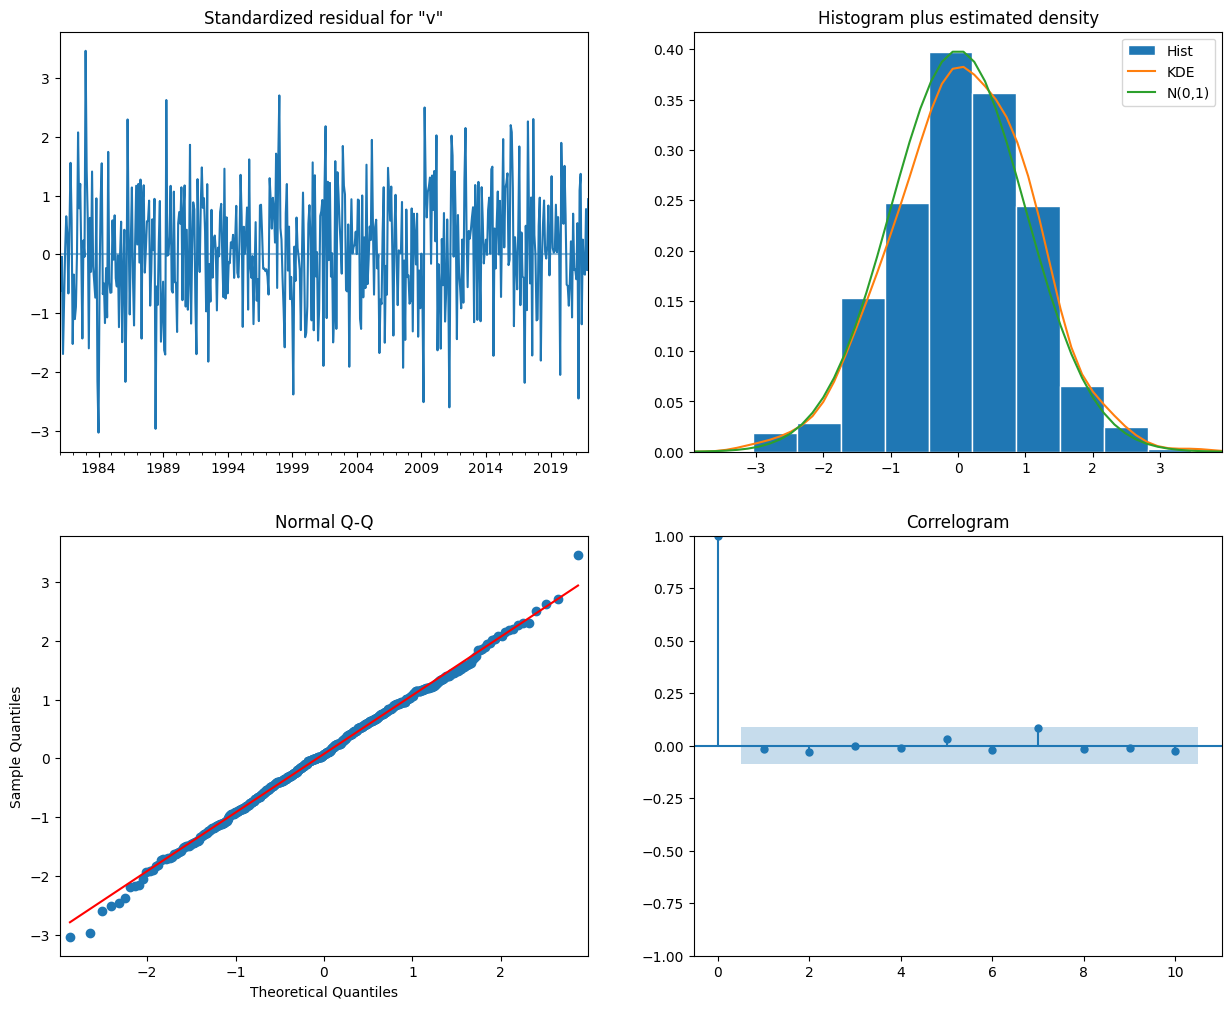

In [123]:
modeloAIC.plot_diagnostics(figsize=(15, 12))
plt.show()

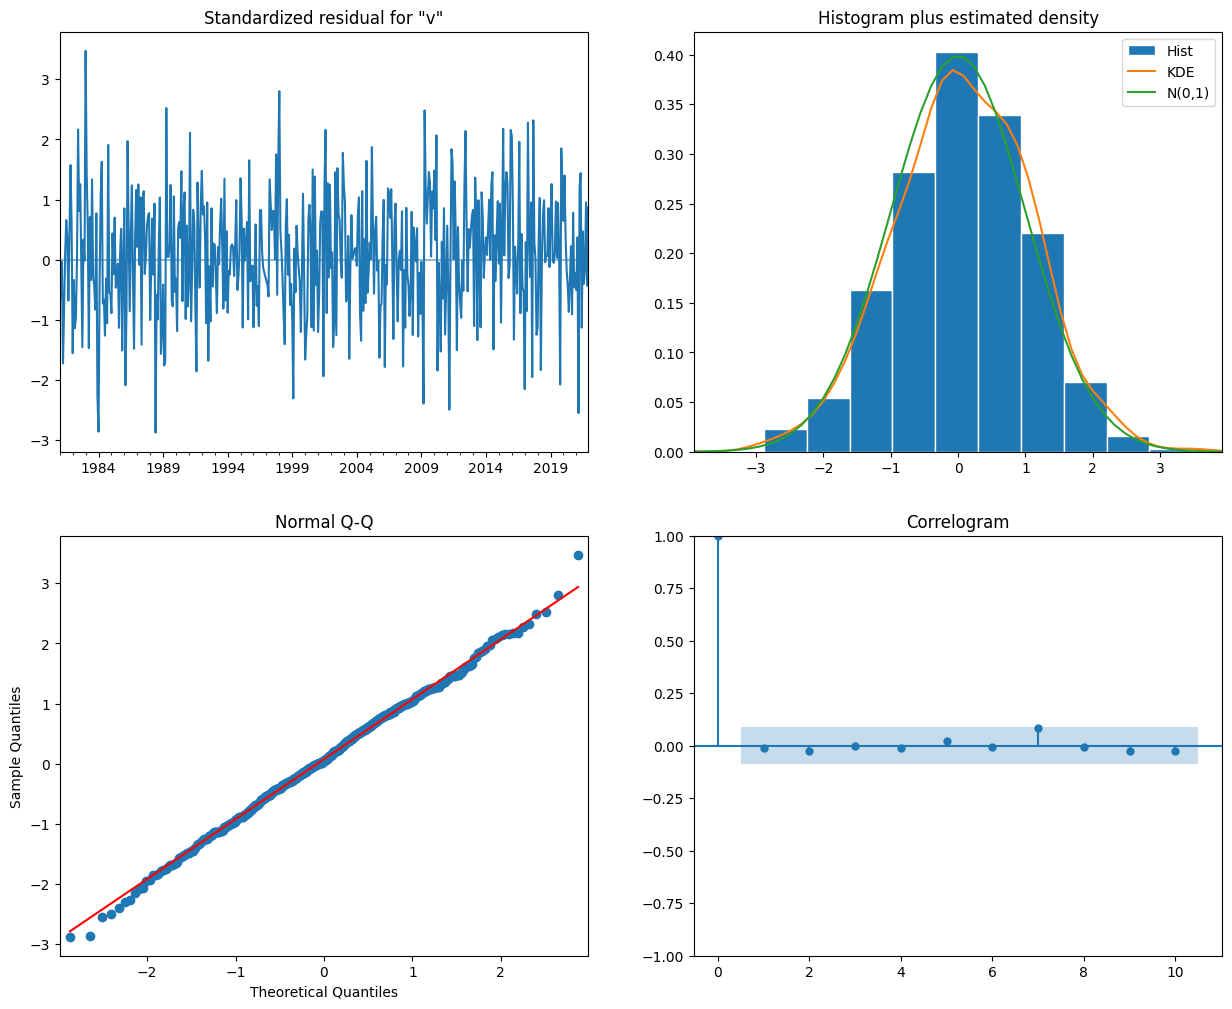

In [124]:
modeloBIC.plot_diagnostics(figsize=(15, 12))
plt.show()

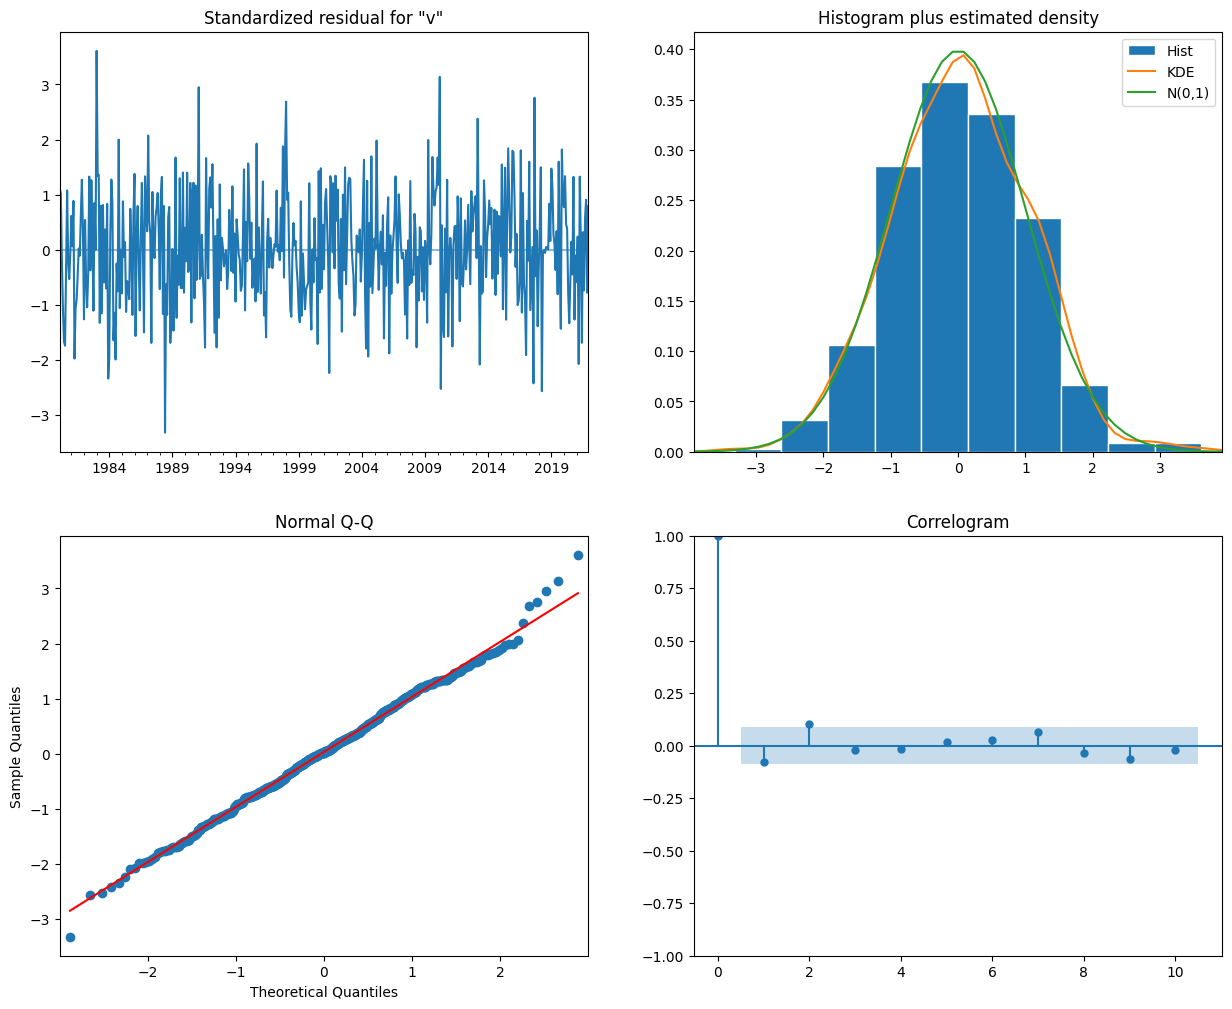

In [125]:
modeloAA.plot_diagnostics(figsize=(15, 12))
plt.show()

## Realización y validación de predicciones

## Conclusiones y recomendaciones